# Parcial 3

### Enunciados Punto 1

Considere las bases de datos del petróleo brent (con nombre __petroleo_brent_historico.csv__) y de la tasa representativa del mercado (__trm_historico.csv__) que se encuentran en la carpeta DATOS del Google Drive.

1. Lea ambas bases de datos.

2. Una las dos bases de datos en una sola BD.

3. Realice un gráfico donde aparezcan ambas series de tiempo.

4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

5. Realice un diagnóstico del modelo y saque conclusiones.

6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.

7. Encuentre un modelo con la función __auto_arima__ para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.

8. Realice un diagnóstico del modelo y saque conclusiones.

9. Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

10. Saque conclusiones.

## 1. Lea ambas bases de datos.

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
 
import pmdarima as pmd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


def printfuller(test_res):
    """ null hypothesis is that a unit root is present in a time series sample."""
    print("Prueba de Dickey Fuller")
    print(f"The test statistic: \t {round(test_res[0], 10)}")
    print(f"p-value: \t \t {test_res[1]}")

plt.style.use('fivethirtyeight')

In [54]:
df = pd.read_csv("../data/petroleo_brent_historico.csv", decimal=",")
dolar = pd.read_csv("../data/trm_historico.csv")

In [55]:
df.Fecha = pd.to_datetime(df.Fecha, format="%d.%m.%Y")

In [56]:
df["fecha"] = df.Fecha
df["petroleo"] = df["Último"]

In [57]:
df = df[["fecha", "petroleo"]]

In [58]:
df.head()

,fecha,petroleo
0,2022-03-14,106.90
1,2022-03-11,112.67
2,2022-03-10,109.33
3,2022-03-09,111.14
4,2022-03-08,127.98


In [59]:
dolar.head()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
0,2850.98,COP,09/10/2002,09/10/2002
1,2854.04,COP,10/10/2002,10/10/2002
2,2870.63,COP,11/10/2002,11/10/2002
3,2861.16,COP,12/10/2002,15/10/2002
4,2852.99,COP,16/10/2002,16/10/2002


In [60]:
dolar["fecha"] = pd.to_datetime(dolar.VIGENCIADESDE, format="%d/%m/%Y")
dolar["dolar"] = dolar.VALOR

In [61]:
dolar = dolar[["fecha", "dolar"]]

## 2. Una las dos bases de datos en una sola BD.

In [62]:
df = df.merge(dolar, on='fecha', how='left')
df = df.dropna()

In [63]:
df = df.sort_values(by=['fecha'])

## 3. Realice un gráfico donde aparezcan ambas series de tiempo.

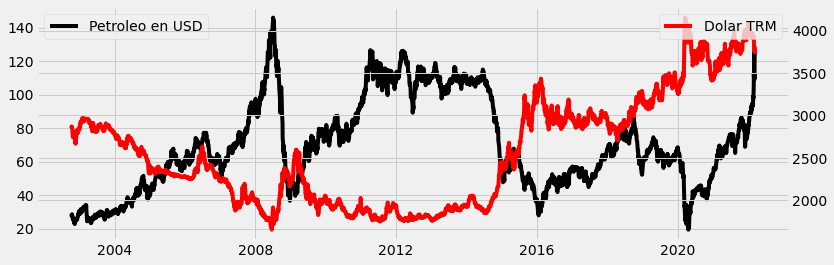

In [64]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
ax1.plot(df.fecha, df.petroleo, color="black", label="Petroleo en USD")
ax2.plot(df.fecha, df.dolar, color="red", label="Dolar TRM")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

## 4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

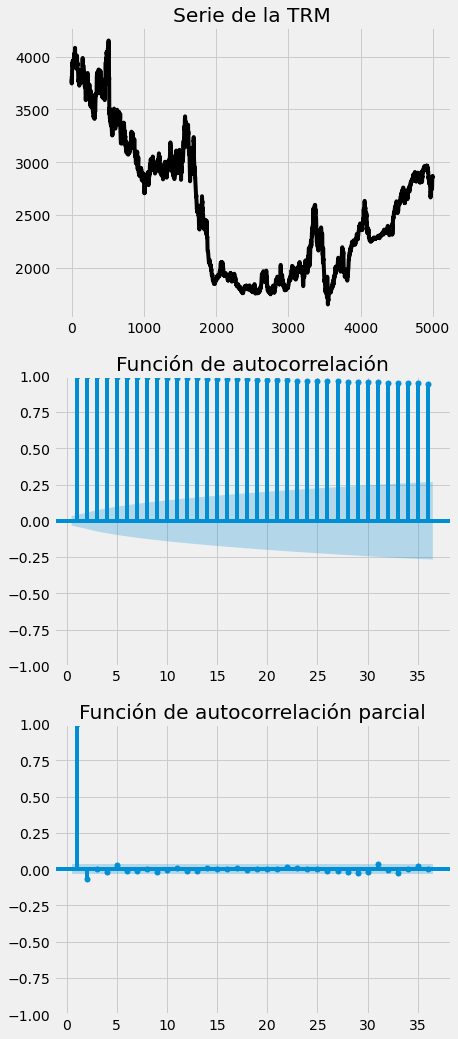

In [65]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
df.dolar.plot(ax=ax[0], title = "Serie de la TRM", xlabel="", color="black")
plot_acf(df.dolar, zero = False, title = "Función de autocorrelación", ax=ax[1])
plot_pacf(df.dolar, method="ywm", zero = False, title = "Función de autocorrelación parcial", ax=ax[2])
fig.show()

Del gráfico de la serie de tiempo no se observa que sea estacionaria, procedemos a observar la función de autocorrelación la cual presenta un decaimiento demasiado lento, por lo cual nos da indicios de que debemos de realizar una diferenciación.

Se realizará una prueba de Dickey-Fuller para verificar si es necesario realizar una diferenciación.

In [66]:
test = adfuller(df.dolar)
printfuller(test)

Prueba de Dickey Fuller
The test statistic: 	 -0.4943040666
p-value: 	 	 0.8931232351189349


Observando el p-valor = 0.8931232351189345 y con una significancia de $\alpha = 0.05$ no se rechaza. Esto quiere decir que no hay estacionaridad en la serie, lo que nos indica que debemos realizar una diferenciación.

Procedemos a diferenciar la serie. 

In [67]:
dolar_diff = df.dolar.diff()
dolar_diff

4999      NaN
4998     3.06
4997    16.59
4994   -17.64
4993     4.14
        ...  
6      -91.18
4       41.64
3      -26.23
2      -40.75
1       39.57
Name: dolar, Length: 3637, dtype: float64

In [68]:
dolar_diff = dolar_diff[-dolar_diff.isna()]
dolar_diff

4998     3.06
4997    16.59
4994   -17.64
4993     4.14
4992    -3.23
        ...  
6      -91.18
4       41.64
3      -26.23
2      -40.75
1       39.57
Name: dolar, Length: 3636, dtype: float64

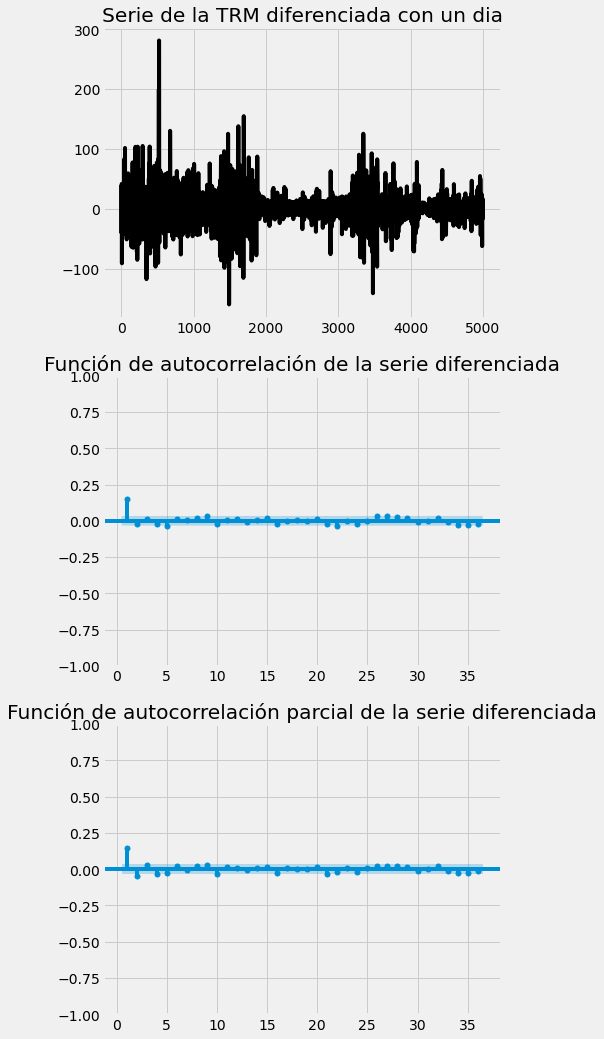

In [69]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
dolar_diff.plot(ax=ax[0], title = "Serie de la TRM diferenciada con un dia", xlabel="", color="black")
plot_acf(dolar_diff, zero = False, title = "Función de autocorrelación de la serie diferenciada", ax=ax[1])
plot_pacf(dolar_diff, method="ywm", zero = False, title = "Función de autocorrelación parcial de la serie diferenciada", ax=ax[2])
fig.show()

In [70]:
test = adfuller(dolar_diff)
printfuller(test)

Prueba de Dickey Fuller
The test statistic: 	 -27.498891546
p-value: 	 	 0.0


Observando el p-valor es menor a 0.05 por se rechaza la hipotesis nula. Esto quiere decir que hay estacionaridad en la serie con una diferenciación.

Despues de realizar la diferenciación se ve que en la ACF hay un corte en el Lag 1 y en la PACF hay un corte en el Lag 1 o 2, se entrenaran varios modelos.

In [71]:
pdq_l = [(p, 1, q) for p in [0, 1, 2, 3] for q in [0, 1, 2, 3]] # ARIMA(0:3, 1, 0:3)

In [72]:
filas = []
for order in pdq_l:
    fit = ARIMA(df.dolar, order=order).fit()
    aic = fit.aic
    bic = fit.bic
    filas.append([order, aic, bic])
filas

[[(0, 1, 0), 33295.1498032477, 33301.348442703],
 [(0, 1, 1), 33210.503851841735, 33222.90113075233],
 [(0, 1, 2), 33209.39997263503, 33227.99589100092],
 [(0, 1, 3), 33210.232801177845, 33235.02735899903],
 [(1, 1, 0), 33216.98773474664, 33229.38501365724],
 [(1, 1, 1), 33208.72846473918, 33227.32438310507],
 [(1, 1, 2), 33210.57747772448, 33235.37203554567],
 [(1, 1, 3), 33212.19433232851, 33243.187529605],
 [(2, 1, 0), 33211.57354238894, 33230.169460754834],
 [(2, 1, 1), 33210.53251436929, 33235.32707219048],
 [(2, 1, 2), 33212.7008982697, 33243.69409554619],
 [(2, 1, 3), 33190.79584411568, 33227.987680847466],
 [(3, 1, 0), 33211.12563695114, 33235.92019477233],
 [(3, 1, 1), 33212.05382796867, 33243.04702524516],
 [(3, 1, 2), 33214.53193918207, 33251.72377591385],
 [(3, 1, 3), 33210.302521184945, 33253.692997372025]]

Nos decidimos a usar el modelo p = 0, d = 1, q = 2 ya que es el que tiene mejor (AIC, BIC) y ademas no tiene muchos parametros.

In [73]:
df = df.reset_index(drop = True)

In [74]:
df

,fecha,petroleo,dolar
0,2002-10-09,28.13,2850.98
1,2002-10-10,27.74,2854.04
2,2002-10-11,27.99,2870.63
3,2002-10-16,28.58,2852.99
4,2002-10-17,27.97,2857.13
...,...,...,...
3632,2022-03-04,118.11,3771.77
3633,2022-03-08,127.98,3813.41
3634,2022-03-09,111.14,3787.18
3635,2022-03-10,109.33,3746.43


In [75]:
fit = ARIMA(df.dolar, order=(0,1,2)).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  dolar   No. Observations:                 3637
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -16601.700
Date:                Tue, 08 Nov 2022   AIC                          33209.400
Time:                        11:32:44   BIC                          33227.996
Sample:                             0   HQIC                         33216.024
                               - 3637                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1565      0.011     14.573      0.000       0.135       0.178
ma.L2         -0.0293      0.011     -2.790      0.005      -0.050      -0.009
sigma2       541.1635      5.127    105.559      0.000     531.115     551.212
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             18711.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5. Realice un diagnóstico del modelo y saque conclusiones.

In [76]:
sm.stats.acorr_ljungbox(fit.resid, lags=range(1, 10 + 1), return_df=True)

,lb_stat,lb_pvalue
1,0.001422,0.969921
2,0.096955,0.952679
3,0.119411,0.989410
4,0.132798,0.997891
5,0.375526,0.995977
6,1.063703,0.983082
7,1.240123,0.989974
8,1.247255,0.996153
9,1.480130,0.997292
10,1.480764,0.998994


Como se puede observar en la tabla anterior, para los lags de 1 al 10 no se rechaza la hipótesis nula, esto quiere decir que hay una evidencia fuerte en contra de la hipótesis alternativa de correlación entre los errores. 

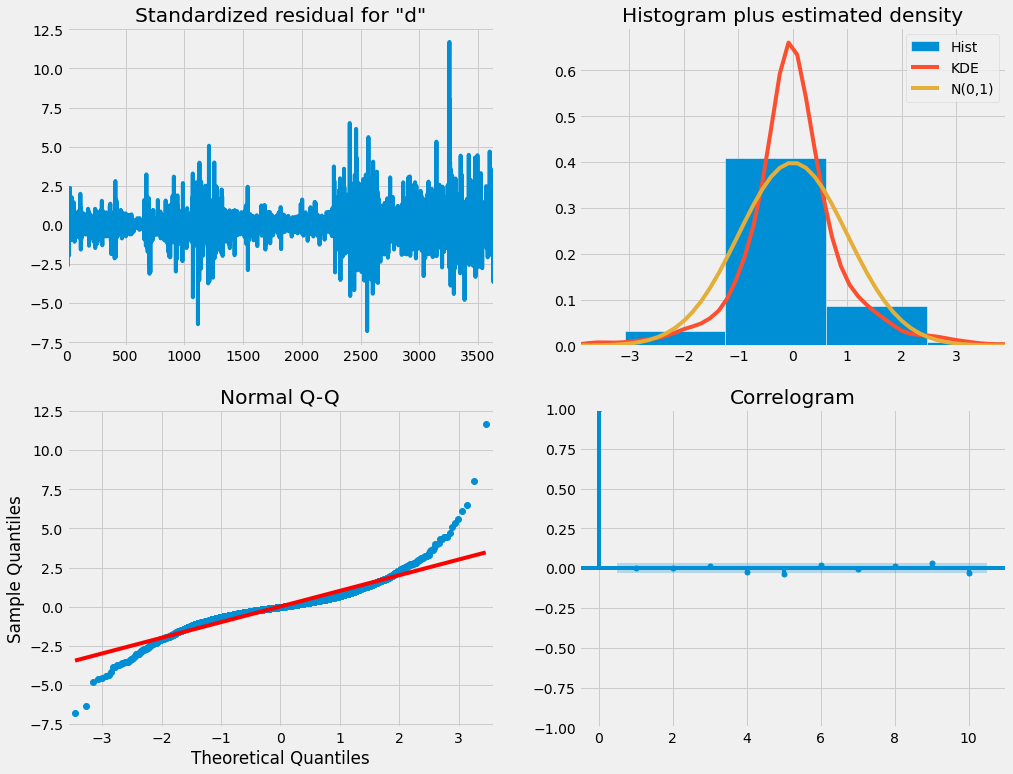

In [77]:
fit.plot_diagnostics(figsize=(15,12))
plt.show()

Como se puede ver en el **summary** del punto anterior el modelo no cumple la normalidad en los errores, se intentaron varios modelos pero ninguno cumple normalidad, a pesar de esto el modelo se puede usar pero teniendo en cuenta que no se deben realizar predicciones muchos dias hacia el futuro. 

## 6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.



In [52]:
#df["petroleo_diff"] = df.petroleo.diff(periods = 7)

In [80]:
df = df.dropna().reset_index(drop = True)

In [81]:
df.shape

(3637, 3)

In [82]:
act = df.petroleo[1:].values
prev = df.petroleo[:3636].values

In [83]:
pct_change = ((act - prev)/prev)*100

In [84]:
df = df[1:].reset_index(drop = True)

Creo la variable **pct_change** que es el cambio porcentual entre el precio del dia actual vs el precio de hace 7 dias.

In [86]:
df["pct_change"] = pct_change

In [87]:
df_len = df.shape[0]
df_len # numero de filas

3636

In [88]:
train = df[:(df_len - 7)]
test = df[(df_len - 7):]
test

,fecha,petroleo,dolar,pct_change
3629,2022-03-02,112.93,3901.62,7.583119
3630,2022-03-03,110.46,3862.95,-2.187196
3631,2022-03-04,118.11,3771.77,6.925584
3632,2022-03-08,127.98,3813.41,8.356617
3633,2022-03-09,111.14,3787.18,-13.158306
3634,2022-03-10,109.33,3746.43,-1.628577
3635,2022-03-11,112.67,3786.00,3.054971


Utilizaremos solo 7 datos (1 semana) para el conjunto de prueba, ya que estos modelos usualmente no se usan para predecir muchos días en el futuro debido a la volatilidad, eventos inesperados y manipulación que estas series presentan.



## 7. Encuentre un modelo con la función auto_arima para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.


In [89]:
fit_X = pmd.arima.auto_arima(y = train["dolar"], X = train[["petroleo", "pct_change"]])

In [90]:
fit_X.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3629
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -16485.293
Date:                Tue, 08 Nov 2022   AIC                          32980.587
Time:                        11:35:22   BIC                          33011.569
Sample:                             0   HQIC                         32991.624
                               - 3629                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
petroleo      -3.3804      0.243    -13.890      0.000      -3.857      -2.903
pct_change     1.4987      0.099     15.150      0.000       1.305       1.693
ma.L1          0.1310      0.010     12.627      0.000       0.111       0.151
ma.L2         -0.0366      0.010     -3.559      0.000      -0.057      -0.016
sigma2       518.1412      5.825     88.944      0.000     506.723     529.559
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16033.99
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.74   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
pred_X, pred_ci = fit_X.predict(n_periods=7, X = test[["petroleo", "pct_change"]], return_conf_int=True)

A continuación se observan los 7 valores al futuro predichos por el modelo.

In [94]:
print(pred_X)

3629    3879.956262
3630    3874.491968
3631    3862.289580
3632    3831.069736
3633    3855.750426
3634    3879.149051
3635    3874.877930
dtype: float64


## 8. Realice un diagnóstico del modelo y saque conclusiones.

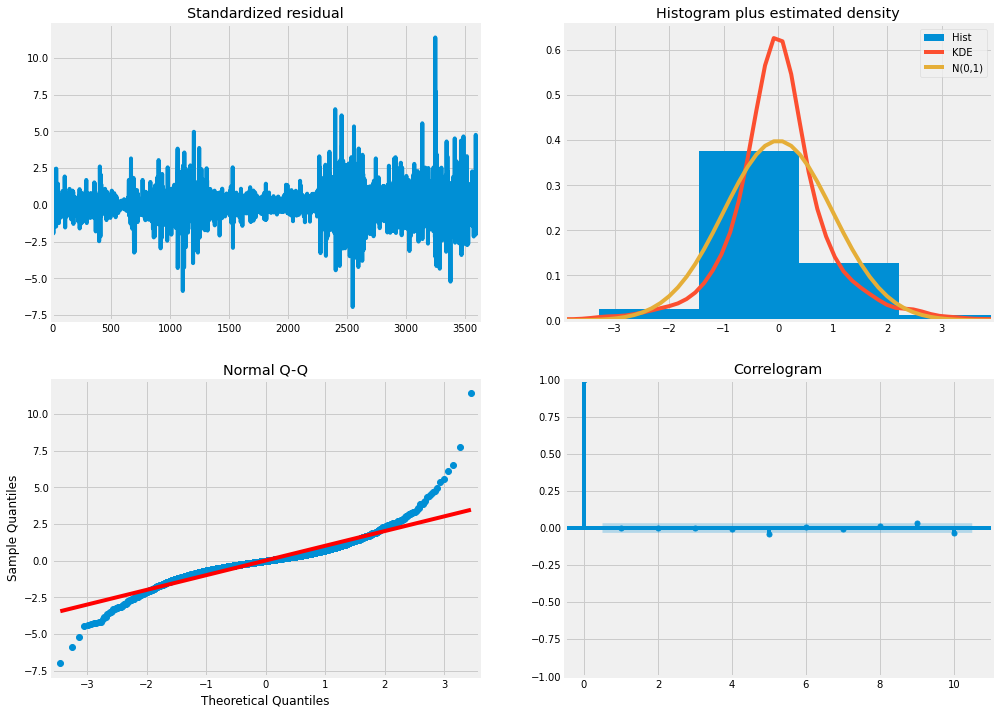

In [37]:
fit_X.plot_diagnostics(figsize=(15,12))
plt.show()

In [114]:
sm.stats.acorr_ljungbox(fit_X.resid())

,lb_stat,lb_pvalue
1,0.050430,0.822317
2,0.158667,0.923732
3,0.196676,0.978124
4,0.244324,0.993119
5,2.344612,0.799693
6,2.606423,0.856372
7,2.667990,0.913925
8,2.706717,0.951394
9,3.103574,0.960046
10,3.141557,0.977894


Como se puede observar en el punto anterior se rechaza la normalidad de los errores y ademas se observa que no hay correlacion entre los errores del Lag 1 al 10.

## 9 . Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

In [117]:
pred_no_X = fit.predict(start = 3622, end = 3628)

- pred_X = Predicción hecha con variables exogenas.
- pred_no_X = Predicción hecha sin variables exogenas
- test.dolar = Valor real de la serie de prueba

In [119]:
pred_X

3629    3879.956262
3630    3874.491968
3631    3862.289580
3632    3831.069736
3633    3855.750426
3634    3879.149051
3635    3874.877930
dtype: float64

In [120]:
test.dolar

3629    3901.62
3630    3862.95
3631    3771.77
3632    3813.41
3633    3787.18
3634    3746.43
3635    3786.00
Name: dolar, dtype: float64

In [126]:
MSE_X = mean_squared_error(test.dolar, pred_X)
MSE_no_X = mean_squared_error(test.dolar, pred_no_X)
MAPE_X = mean_absolute_percentage_error(test.dolar, pred_X)
MAPE_no_X = mean_absolute_percentage_error(test.dolar, pred_no_X)

print("Root Mean Square Error:")
print("- con variables exogenas " + str(math.sqrt(MSE_X)))
print("- sin variables exogenas " + str(math.sqrt(MSE_no_X)))

print("\n")
print("MAPE:")
print("- con variables exogenas " + str(MAPE_X*100))
print("- sin variables exogenas " + str(MAPE_no_X*100))

Root Mean Square Error:
- con variables exogenas 74.9511569744772
- sin variables exogenas 139.8273561794574


MAPE:
- con variables exogenas 1.6311053087515812
- sin variables exogenas 3.3750513095021923


## 10. Saque conclusiones.

Se puede ver que con el **modelo entrenado inicialmente (sin variables exógenas)** se obtiene un **RMSE de 139.8 y un MAPE de 3.37**, mientras que cuando se consideran las **dos variables exógenas** de precio de petróleo y cambio porcentual respecto al día anterior de este, se observa un **RMSE de 74.9 y un MAPE de 3.37**, esto es una reducción en el error de **alrededor del 50%**.

Si se tiene en cuenta que el dólar para la cola de esta base de datos toma valores alrededor de 3900, un RMSE de 74 se puede considerar aceptable, depende mucho del uso que se le vaya a dar a este.

